<a href="https://colab.research.google.com/github/Lucia1009/TFG-Plataforma-para-la-prediccion-de-potencia-electrica-generada-en-parques-eolicos/blob/desarrollo/modelos/prediccion_de_potencias_con_regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install darts -q
!pip install dash -q

#Random forest
!pip install --upgrade tensorflow -q
# !pip install --upgrade keras -q
!pip install --upgrade tensorflow tensorflow_decision_forests -q
!pip install wurlitzer -q
!pip install scikeras -q
!pip install keras-tuner -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import R2Score

# random forest #
import tensorflow_decision_forests as tfdf
import ydf
import keras_tuner as kt
from wurlitzer import sys_pipes
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
#               #


import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

from google.colab import drive

In [3]:
drive.mount('/content/drive', force_remount=False)

df=pd.read_csv('/content/drive/MyDrive/TFG/elvalle_reparto_saltos_sp75.csv', delimiter=";",decimal=".",skiprows = [1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_filtrado=df[(df['TIME'] % 600==540)]
print(df_filtrado.shape)
print(df.shape)

# for col in df_filtrado:
#     print("\n",col, "\n", df_filtrado[col].unique())

(21600, 150)
(216000, 150)


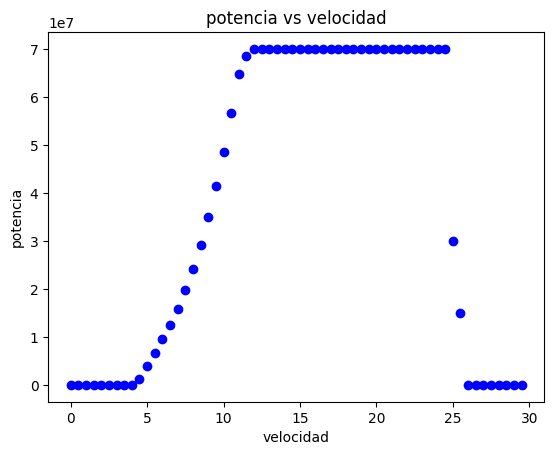

360


In [5]:
# unique_wd, counts = np.unique(df_filtrado['wd'], return_counts=True)
# print(counts, "\n", unique_wd )

direcciones={}
for i in range(0,360):
    # Separo los datos para cada dirección
    filtered_data = df_filtrado[(df_filtrado['wd'] <= i) & (df_filtrado['wd'] > (i - 1 ))]

    # Selecciono solo las columnas que me interesan
    selected_columns = filtered_data[['ws', 'WF_Power', 'wd']]

    direcciones[i]=selected_columns
    # print(i, direcciones[i])

plt.title("potencia vs velocidad")
plt.scatter(direcciones[1]['ws'], direcciones[1]['WF_Power'], color="blue")

plt.xlabel("velocidad")
plt.ylabel("potencia")
plt.show()
print(len(direcciones))

In [6]:
datos = pd.DataFrame(df_filtrado[['wd', 'ws', 'WF_Power']])

datos['sin_wd'] = np.sin(datos['wd']*np.pi/180)
datos['cos_wd'] = np.cos(datos['wd']*np.pi/180)
datos = datos.drop('wd', axis=1)


datos.tail()

,ws,WF_Power,sin_wd,cos_wd
215959,27.500000,1.157064e-41,-0.017452,0.999848
215969,28.000000,-1.711043e-52,-0.017452,0.999848
215979,28.500000,6.197535e-59,-0.017452,0.999848
215989,29.000000,7.481889e-71,-0.017452,0.999848
215999,29.500001,-1.019971e-84,-0.017452,0.999848






---

<br>


# Regresión polinómica

In [7]:
#### OBTENCIÓN DE DATOS ESTRATIFICADOS ####

datos_train = []
datos_test = []
for i in range(datos.shape[0]):

  if i%4==0:
      datos_test.append(datos.iloc[i])
  else:
      datos_train.append(datos.iloc[i])

print(len(datos_train), len(datos_test))
print(datos.shape[0]/len(datos_test))
print(datos.shape[0]/4)

print(datos_train[0], "\n", datos_train[1])

datos_train = pd.DataFrame(datos_train)
datos_test = pd.DataFrame(datos_test)

X_train_p = datos_train.drop('WF_Power', axis=1)
y_train_p = datos_train['WF_Power']

X_test_p = datos_test.drop('WF_Power', axis=1)
y_test_p = datos_test['WF_Power']

X_train_p.head(10)



#### OBTENCIÓN DE DATOS ALEATORIOS ####

# datos_x = datos.drop('WF_Power', axis=1)
# datos_y = datos['WF_Power']

# #Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
# X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(datos_x, datos_y, test_size=0.2 )


16200 5400
4.0
5400.0
ws          5.000000e-01
WF_Power    2.704126e-41
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 19, dtype: float64 
 ws          1.000000e+00
WF_Power    1.847847e-58
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 29, dtype: float64


,ws,sin_wd,cos_wd
19,0.5,0.0,1.0
29,1.0,0.0,1.0
39,1.5,0.0,1.0
59,2.5,0.0,1.0
69,3.0,0.0,1.0
79,3.5,0.0,1.0
99,4.5,0.0,1.0
109,5.0,0.0,1.0
119,5.5,0.0,1.0
139,6.5,0.0,1.0


In [8]:
#### CREACIÓN DEL MODELO ####

#Transformamos los datos
transformador = Pipeline([('scaler', StandardScaler()),  # normaliza los datos
                  ('poly', PolynomialFeatures(degree=15))]) ################ grado


X_train_p_transf  = transformador.fit_transform(X_train_p)
X_test_p_transf = transformador.transform(X_test_p)

print(X_train_p_transf.shape[1])


816


In [9]:
### Creamos el modelo ###

def build_model(input_shape):
  model_nn = keras.Sequential([
    keras.layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

  model_nn.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'R2Score'])
  return model_nn

model_nn = build_model(X_train_p_transf.shape[1])

#Entrenamos el modelo
model_nn.fit(X_train_p_transf, y_train_p, epochs=40, verbose=1)   ############## epochs

#Evaluamos el modelo
model_nn.evaluate(X_test_p_transf, y_test_p)


Epoch 1/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - R2Score: -1.5043 - loss: 2519533847838720.0000 - mae: 38931092.0000 - mse: 2519533847838720.0000
Epoch 2/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - R2Score: -1.4650 - loss: 2485245244866560.0000 - mae: 38882080.0000 - mse: 2485245244866560.0000
Epoch 3/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - R2Score: -1.3687 - loss: 2386821774311424.0000 - mae: 38530284.0000 - mse: 2386821774311424.0000
Epoch 4/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - R2Score: -1.0975 - loss: 2130641739055104.0000 - mae: 36453164.0000 - mse: 2130641739055104.0000
Epoch 5/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - R2Score: -0.8371 - loss: 1849501367140352.0000 - mae: 34115572.0000 - mse: 1849501367140352.0000
Epoch 6/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: -0.5319 - loss: 1547112584052736.0000 - mae: 30935348.0000 - mse: 1547112584052736.0000
Epoch 7/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - R2Score: -0.2895 - loss: 129838458549043

[27648489160704.0, 3374033.0, 27648489160704.0, 0.9731577634811401]

In [10]:
#### GRÁFICA REGRESIÓN POLINOMIAL ####

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo = np.sin(angulo * np.pi / 180)
    cos_angulo = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos (tanto entrenamiento como test) con el ángulo
    df_filtrado_datos = datos[(datos['sin_wd'] == sin_angulo) &
                              (datos['cos_wd'] == cos_angulo)]

    if not df_filtrado_datos.empty:
        # Ordenar por velocidad del viento (ws)
        df_filtrado_datos = df_filtrado_datos.sort_values(by='ws')
        y_filtrado_datos = df_filtrado_datos['WF_Power']

        # Filtrar los datos de test
        df_filtrado_graf = X_test_p[(X_test_p['sin_wd'] == sin_angulo) &
                                    (X_test_p['cos_wd'] == cos_angulo)]

        if not df_filtrado_graf.empty:
            y_filtrado = y_test_p.loc[df_filtrado_graf.index]

            # Transformar los datos filtrados para predicción
            df_filtrado_transf = transformador.transform(df_filtrado_graf)
            y_pred_filtrado = model_nn.predict(df_filtrado_transf)

            # Crear la gráfica con los datos reales y las predicciones
            fig = go.Figure()

            # Datos reales (puntos)
            fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_filtrado,
                                     mode='markers', name='Potencia real',
                                     marker=dict(color='blue')))

            # Predicciones (puntos)
            fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_pred_filtrado.flatten(),
                                     mode='markers', name='Potencia predicha',
                                     marker=dict(color='red')))

            # Línea continua para las predicciones
            rango_x = np.linspace(df_filtrado_graf['ws'].min(), df_filtrado_graf['ws'].max(), 100)

            # Crear un DataFrame para el rango
            rango_df = pd.DataFrame({'ws': rango_x, 'sin_wd': [sin_angulo] * 100, 'cos_wd': [cos_angulo] * 100})

            # Transformar el rango de x
            rango_x_transf = transformador.transform(rango_df)

            # Predicción de los valores en el rango
            rango_y_pred = model_nn.predict(rango_x_transf)
            fig.add_trace(go.Scatter(x=rango_x, y=rango_y_pred.flatten(), mode='lines', name='Línea predicción', line=dict(color='red')))

        # Interpolar una línea de los valores reales
        rango_y_real = np.interp(rango_x, df_filtrado_datos['ws'], y_filtrado_datos)

        # Línea continua para los valores reales
        fig.add_trace(go.Scatter(x=rango_x, y=rango_y_real, mode='lines', name='Línea real', line=dict(color='blue')))

        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})


if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


<IPython.core.display.Javascript object>



---

<br>

# Random forest

In [11]:
#### DATOS ESTRATIFICADOS ####

datos_train_rf = []
datos_test_rf = []
for i in range(datos.shape[0]):

  if i%4==0:
      datos_test_rf.append(datos.iloc[i])
  else:
      datos_train_rf.append(datos.iloc[i])

print(len(datos_train_rf), len(datos_test_rf))
print(datos.shape[0]/len(datos_test_rf))
print(datos.shape[0]/4)

print(datos_train_rf[0], "\n", datos_train_rf[1])

dftrain = pd.DataFrame(datos_train_rf)
dftest = pd.DataFrame(datos_test_rf)

# Todas las columnas menos el label
using_col_list = [col for col in dftrain.columns if col != 'WF_Power']
print(using_col_list)

feature_list = []
for col in using_col_list:

   feature_list.append(tfdf.keras.FeatureUsage(name=col,semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

trainds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='WF_Power',task = tfdf.keras.Task.REGRESSION)
testds = tfdf.keras.pd_dataframe_to_tf_dataset(dftest, label='WF_Power',task = tfdf.keras.Task.REGRESSION)


16200 5400
4.0
5400.0
ws          5.000000e-01
WF_Power    2.704126e-41
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 19, dtype: float64 
 ws          1.000000e+00
WF_Power    1.847847e-58
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 29, dtype: float64
['ws', 'sin_wd', 'cos_wd']


In [12]:
#### DATOS ALEATORIOS ####

# #vuelvo a separar en conjuntos la variable datos
# dftrain, dftest = train_test_split(datos, test_size=0.2)

# # Todas las columnas menos el label
# datos_col = [col for col in dftrain.columns if col != 'WF_Power']
# print(datos_col)

# feature_list = []
# for col in datos_col:

#    feature_list.append(tfdf.keras.FeatureUsage(name=col,semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

# trainds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='WF_Power',task = tfdf.keras.Task.REGRESSION)
# testds = tfdf.keras.pd_dataframe_to_tf_dataset(dftest, label='WF_Power',task = tfdf.keras.Task.REGRESSION)


In [13]:
#### MODELO ####

model_rf = tfdf.keras.RandomForestModel(features = feature_list, task = tfdf.keras.Task.REGRESSION,
                                    #exclude_non_specified_features=True, #innsecesario porque ya hemos quitado el label
                                    num_trees=301, max_depth=10,
                                    split_axis="SPARSE_OBLIQUE",categorical_algorithm="RANDOM",
                                    missing_value_policy='RANDOM_LOCAL_IMPUTATION',
                                    sparse_oblique_normalization='STANDARD_DEVIATION',
                                    compute_oob_variable_importances=True,
                                    winner_take_all=False)


model_rf.compile(metrics=["Accuracy"])

with sys_pipes():
    model_rf.fit(trainds)

Use /tmp/tmpclbrs4jx as temporary training directory
Reading training dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
Training dataset read in 0:00:10.048283. Found 16200 examples.
Training model...


I0000 00:00:1738579414.301571   39107 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738579414.301688   39107 kernel.cc:783] Collect training examples
I0000 00:00:1738579414.301714   39107 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^ws$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^sin_wd$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^cos_wd$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738579414.302495   39107 kernel.cc:401] Number of batches: 17
I0000 00:00:1738579414.302529   39107 kernel.cc:402] Number of examples: 16200
I0000 00:00:1738579414.308364   39107 kernel.cc:802] Training dataset:
Number of records: 16200
Number of columns: 4

Number

Model trained in 0:00:31.021135
Compiling model...
Model compiled.


In [14]:
inspector = model_rf.make_inspector()
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 MEAN_INCREASE_IN_RMSE
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [15]:
inspector.variable_importances()["MEAN_INCREASE_IN_RMSE"]

[("ws" (1; #3), 25955688.0),
 ("cos_wd" (1; #1), 1690523.5),
 ("sin_wd" (1; #2), 733264.0)]

In [16]:
#### GRÁFICA RANDOM FOREST ####

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_total = datos[(datos['sin_wd'] == sin_angulo_val) &
                              (datos['cos_wd'] == cos_angulo_val)]

    # Comprobar si el filtrado contiene datos
    if not datos_filtrados_total.empty:
        # Ordenar por velocidad del viento (ws)
        datos_filtrados_total = datos_filtrados_total.sort_values(by='ws')
        y_filtrados_total = datos_filtrados_total['WF_Power']

        # Filtrar los datos de test
        datos_filtrados_graf = dftest[(dftest['sin_wd']== sin_angulo_val) &
                                      (dftest['cos_wd']== cos_angulo_val)]



        y_filtrado_graf = datos_filtrados_graf['WF_Power']

        # Convertimos a dataset de TensorFlow Decision Forests
        test_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset(datos_filtrados_graf, task=tfdf.keras.Task.REGRESSION)

        # Hacer predicciones con el modelo

        y_pred_filtrado_graf = model_rf.predict(test_df_transf_graf)


        # Crear la gráfica con los datos reales y las predicciones
        fig = go.Figure()

        # Datos reales (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_filtrado_graf,
                                  mode='markers', name='Potencia real',
                                  marker=dict(color='blue')))

        # Predicciones (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_pred_filtrado_graf.flatten(),
                                  mode='markers', name='Potencia predicha',
                                  marker=dict(color='red')))

        rango_x_graf = datos_filtrados_total['ws']


        rango_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset( datos_filtrados_total[['ws', 'sin_wd', 'cos_wd']], task=tfdf.keras.Task.REGRESSION)

        # Predecir los valores en el rango
        rango_y_pred_graf = model_rf.predict(rango_df_transf_graf).flatten()
        # Interpolación de los valores reales
        rango_y_real_graf = np.interp(rango_x_graf, datos_filtrados_total['ws'], y_filtrados_total)

        # Añadir las líneas a la gráfica
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf, mode='lines', name='Línea predicción', line=dict(color='red')))
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_real_graf, mode='lines', name='Línea real', line=dict(color='blue')))

        fig.update_layout(
          title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)



<IPython.core.display.Javascript object>

## Random forest con ydf

In [17]:
#### MODELO ####

learner = ydf.RandomForestLearner(label="WF_Power", task = ydf.Task.REGRESSION,
                                    num_trees=301, max_depth=10,
                                    split_axis="SPARSE_OBLIQUE",categorical_algorithm="RANDOM",
                                    missing_value_policy='RANDOM_LOCAL_IMPUTATION',
                                    sparse_oblique_normalization='STANDARD_DEVIATION',
                                    compute_oob_variable_importances=True,
                                    winner_take_all=False)
model_le=learner.train(dftrain)
evaluation = learner.cross_validation(dftest)

# Print the evaluation
print(evaluation)


# model_le.evaluate(dftest)  #Equivale a imprimir la evaluación

Train model on 16200 examples
1/1 [==============================] - 0s 214ms/step
Model trained in 0:00:26.297551
RMSE: 346775
num examples: 5400
num examples (weighted): 5400



In [ ]:
#### GRÁFICA RANDOM FOREST YDF ####

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_total = datos[(datos['sin_wd'] == sin_angulo_val) &
                              (datos['cos_wd'] == cos_angulo_val)]

    # Comprobar si el filtrado contiene datos
    if not datos_filtrados_total.empty:
        # Ordenar por velocidad del viento (ws)
        datos_filtrados_total = datos_filtrados_total.sort_values(by='ws')
        y_filtrados_total = datos_filtrados_total['WF_Power']

        # Filtrar los datos de test
        datos_filtrados_graf = dftest[(dftest['sin_wd']== sin_angulo_val) &
                                      (dftest['cos_wd']== cos_angulo_val)]


        y_filtrado_graf = datos_filtrados_graf['WF_Power']


        # Hacer predicciones con el modelo
        y_pred_filtrado_graf = model_le.predict(datos_filtrados_graf)


        # Crear la gráfica con los datos reales y las predicciones
        fig = go.Figure()

        # Datos reales (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_filtrado_graf,
                                  mode='markers', name='Potencia real',
                                  marker=dict(color='blue')))

        # Predicciones (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_pred_filtrado_graf.flatten(),
                                  mode='markers', name='Potencia predicha',
                                  marker=dict(color='red')))

        rango_x_graf = datos_filtrados_total['ws']

        # Predecir los valores en el rango
        rango_y_pred_graf = model_le.predict(datos_filtrados_total[['ws', 'sin_wd', 'cos_wd']])
        # Interpolación de los valores reales
        rango_y_real_graf = np.interp(rango_x_graf, datos_filtrados_total['ws'], y_filtrados_total)

        # Añadir las líneas a la gráfica
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf, mode='lines', name='Línea predicción', line=dict(color='red')))
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_real_graf, mode='lines', name='Línea real', line=dict(color='blue')))


        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})

if __name__ == '__main__':
    app.run_server(debug=True, port=8052)



## Comparación ambos modelos de random forest

In [27]:
#### GRÁFICA COMPARACION DE RANDOM FOREST ####

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_total = datos[(datos['sin_wd'] == sin_angulo_val) &
                              (datos['cos_wd'] == cos_angulo_val)]

    # Comprobar si el filtrado contiene datos
    if not datos_filtrados_total.empty:
        # Ordenar por velocidad del viento (ws)
        datos_filtrados_total = datos_filtrados_total.sort_values(by='ws')
        y_filtrados_total = datos_filtrados_total['WF_Power']

        # Filtrar los datos de test
        datos_filtrados_graf = dftest[(dftest['sin_wd']== sin_angulo_val) &
                                      (dftest['cos_wd']== cos_angulo_val)]


        y_filtrado_graf = datos_filtrados_graf['WF_Power']


        # Hacer predicciones con el modelo
        y_pred_filtrado_graf = model_le.predict(datos_filtrados_graf)

        # Convertimos a dataset de TensorFlow Decision Forests
        test_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset(datos_filtrados_graf, task=tfdf.keras.Task.REGRESSION)

        # Hacer predicciones con el modelo

        y_pred_filtrado_graf_rf = model_rf.predict(test_df_transf_graf)


        # Crear la gráfica con los datos reales y las predicciones
        fig = go.Figure()

        # Datos reales (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_filtrado_graf,
                                  mode='markers', name='Potencia real',
                                  marker=dict(color='blue')))

        # Predicciones (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_pred_filtrado_graf.flatten(),
                                  mode='markers', name='Potencia predicha',
                                  marker=dict(color='red')))

        rango_x_graf = datos_filtrados_total['ws']

        # Predecir los valores en el rango
        rango_y_pred_graf = model_le.predict(datos_filtrados_total[['ws', 'sin_wd', 'cos_wd']])
        # Interpolación de los valores reales
        rango_y_real_graf = np.interp(rango_x_graf, datos_filtrados_total['ws'], y_filtrados_total)

        # Añadir las líneas a la gráfica
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf, mode='lines', name='Línea predicción ydf', line=dict(color='red')))
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_real_graf, mode='lines', name='Línea real', line=dict(color='blue')))

        # Predecir los valores en el rango
        rango_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset( datos_filtrados_total[['ws', 'sin_wd', 'cos_wd']], task=tfdf.keras.Task.REGRESSION)
        rango_y_pred_graf_rf = model_rf.predict(rango_df_transf_graf).flatten()
        # Interpolación de los valores reales
        rango_y_real_graf = np.interp(rango_x_graf, datos_filtrados_total['ws'], y_filtrados_total)

        # Añadir las líneas a la gráfica
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf_rf, mode='lines', name='Línea predicción rf', line=dict(color='green')))


        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})

if __name__ == '__main__':
    app.run_server(debug=True, port=8052)



<IPython.core.display.Javascript object>



---

<br>

# Prueba de los modelos sobre las potencias de cada turbina

In [19]:
#### PRUEBA DE QUE NO VALE EL MISMO MODELO ####

# print(df_filtrado.columns)

# Initialize selected_columns as a dictionary for each direction
selected_columns_2 = ['wd']

for j in range(1,15):
  # Selecciono solo las columnas que me interesan
  selected_columns_2.append('TC'+str(j)+'.T.Pg.signal[1]')
  if j<10:

    selected_columns_2.append('v[0'+str(j)+']')
  else:
    selected_columns_2.append('v['+str(j)+']')


datos_turbinas=df_filtrado[selected_columns_2].copy()
datos_turbinas['sin_wd'] = np.sin(datos_turbinas['wd']*np.pi/180)
datos_turbinas['cos_wd'] = np.cos(datos_turbinas['wd']*np.pi/180)
datos_turbinas = datos_turbinas.drop('wd', axis=1)

# print(  datos_turbinas.columns)

app = dash.Dash(__name__)

app.layout = html.Div([

    html.Div([
        "Ángulo de viento: ",
        dcc.Input(id='angulo', value=0, type='number')
    ]),
    html.Div([
        "Numero de la turbina: ",
        dcc.Input(id='turbina', value=1, type='number')
    ]),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('graph', 'figure'),
    Input('angulo', 'value'),
    Input('turbina', 'value'))
def update_output_div(angulo, turbina):

    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    if turbina<10:
      velocidad='v[0'+str(turbina)+']'
    else:
      velocidad='v['+str(turbina)+']'

    potencia='TC'+str(turbina)+'.T.Pg.signal[1]'


    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_total = datos_turbinas[(datos_turbinas['sin_wd'] == sin_angulo_val) &
                              (datos_turbinas['cos_wd'] == cos_angulo_val)][[velocidad, potencia]]

    # Comprobar si el filtrado contiene datos
    if not datos_filtrados_total.empty:
        # Ordenar por velocidad del viento
        datos_filtrados_total = datos_filtrados_total.sort_values(by=velocidad)
        y_filtrados_total = datos_filtrados_total[potencia]

        # Filtrar los datos de predicción de las turbinas individuales
        datos_filtrados_graf =datos_turbinas[(datos_turbinas['sin_wd'] == sin_angulo_val) &
                              (datos_turbinas['cos_wd'] == cos_angulo_val)][[velocidad, 'sin_wd', 'cos_wd']]

        datos_filtrados_graf = datos_filtrados_graf.rename(columns={velocidad: 'ws'})

        # Crear la gráfica solo si hay datos filtrados de test
        if not datos_filtrados_graf.empty:
            y_filtrado_graf = datos_filtrados_total[potencia]

            # Convertimos a dataset de TensorFlow Decision Forests
            test_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset(datos_filtrados_graf, task=tfdf.keras.Task.REGRESSION)

            # Hacer predicciones con el modelo

            y_pred_filtrado_graf = model_rf.predict(test_df_transf_graf)



            # Crear la gráfica con los datos reales y las predicciones
            fig = go.Figure()

            # Datos reales (puntos)
            fig.add_trace(go.Scatter(x=datos_filtrados_total[velocidad], y=y_filtrado_graf,
                                      mode='markers', name='Potencia real',
                                      marker=dict(color='blue')))

            # Predicciones (puntos)
            fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_pred_filtrado_graf.flatten(),
                                      mode='markers', name='Potencia predicha',
                                      marker=dict(color='red')))

            # Línea continua para las predicciones
            rango_x_graf = np.linspace(datos_filtrados_graf['ws'].min(), datos_filtrados_graf['ws'].max(), 100)

            # Crear un DataFrame para el rango
            rango_df_graf = pd.DataFrame({'ws': rango_x_graf, 'sin_wd': [sin_angulo_val] * 100, 'cos_wd': [cos_angulo_val] * 100})

            # Convertir rango_df_graf en dataset
            rango_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset(rango_df_graf, task=tfdf.keras.Task.REGRESSION)

            # Predicción de los valores en el rango
            try:
                rango_y_pred_graf = model_rf.predict(rango_df_transf_graf)
                fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf.flatten(), mode='lines', name='Línea predicción', line=dict(color='red')))
            except Exception as e:
                print(f"Error en la predicción del rango: {e}")

        # Interpolación de los valores reales
        rango_y_real_graf = np.interp(rango_x_graf, datos_filtrados_total[velocidad], y_filtrados_total)

        # Línea continua para los valores reales
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_real_graf, mode='lines', name='Línea real', line=dict(color='blue')))

        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento ("+velocidad+")",
            yaxis_title="Potencia ("+potencia+")"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento ('+velocidad+')', 'y': 'Potencia ('+potencia+')'})
    datos_filtrados_graf = datos_filtrados_graf.rename(columns={'ws': velocidad})

if __name__ == '__main__':
    app.run_server(debug=True, port=8053)





<IPython.core.display.Javascript object>



---

<br>

# Guardado de modelos

In [20]:
"""Regresión polinomial"""

model_nn.save('model_nn.keras')


In [21]:
model_nuevo=tf.keras.models.load_model('model_nn.keras')

model_nuevo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          52,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,205 (637.52 KB)

 Trainable params: 54,401 (212.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,804 (425.02 KB)

In [22]:
#### GRÁFICA REGRESIÓN POLINOMIAL MODELO GUARDADO ####

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo = np.sin(angulo * np.pi / 180)
    cos_angulo = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos (tanto entrenamiento como test) con el ángulo
    df_filtrado_datos = datos[(datos['sin_wd'] == sin_angulo) &
                              (datos['cos_wd'] == cos_angulo)]

    if not df_filtrado_datos.empty:
        # Ordenar por velocidad del viento (ws)
        df_filtrado_datos = df_filtrado_datos.sort_values(by='ws')
        y_filtrado_datos = df_filtrado_datos['WF_Power']

        # Filtrar los datos de test
        df_filtrado_graf = X_test_p[(X_test_p['sin_wd'] == sin_angulo) &
                                    (X_test_p['cos_wd'] == cos_angulo)]

        if not df_filtrado_graf.empty:
            y_filtrado = y_test_p.loc[df_filtrado_graf.index]

            # Transformar los datos filtrados para predicción
            df_filtrado_transf = transformador.transform(df_filtrado_graf)
            y_pred_filtrado = model_nuevo.predict(df_filtrado_transf)

            # Crear la gráfica con los datos reales y las predicciones
            fig = go.Figure()

            # Datos reales (puntos)
            fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_filtrado,
                                     mode='markers', name='Potencia real',
                                     marker=dict(color='blue')))

            # Predicciones (puntos)
            fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_pred_filtrado.flatten(),
                                     mode='markers', name='Potencia predicha',
                                     marker=dict(color='red')))

            # Línea continua para las predicciones
            rango_x = np.linspace(df_filtrado_graf['ws'].min(), df_filtrado_graf['ws'].max(), 100)

            # Crear un DataFrame para el rango
            rango_df = pd.DataFrame({'ws': rango_x, 'sin_wd': [sin_angulo] * 100, 'cos_wd': [cos_angulo] * 100})

            # Transformar el rango de x
            rango_x_transf = transformador.transform(rango_df)

            # Predicción de los valores en el rango
            rango_y_pred = model_nuevo.predict(rango_x_transf)
            fig.add_trace(go.Scatter(x=rango_x, y=rango_y_pred.flatten(), mode='lines', name='Línea predicción', line=dict(color='red')))

        # Interpolar una línea de los valores reales
        rango_y_real = np.interp(rango_x, df_filtrado_datos['ws'], y_filtrado_datos)

        # Línea continua para los valores reales
        fig.add_trace(go.Scatter(x=rango_x, y=rango_y_real, mode='lines', name='Línea real', line=dict(color='blue')))

        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})


if __name__ == '__main__':
    app.run_server(debug=True, port=8054)


<IPython.core.display.Javascript object>

In [23]:
"""Random Forest YDF"""

!pip install joblib
import joblib

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 [==============================] - 0s 41ms/step


In [24]:
joblib.dump(model_le, 'model_le.joblib')


[Warning] Model pickling is discouraged. To save a model on disk, use `model.save(path)` and `... = ydf.load_model(path)` instead. To serialize a model to bytes, use `data = model.serialize()` and `... = ydf.deserialize_model(data)` instead.


['model_le.joblib']

In [25]:
model_nuevo_le = joblib.load('model_le.joblib')

model_nuevo_le.describe()

1/1 [==============================] - 0s 433ms/step


In [26]:
#### GRÁFICA RANDOM FOREST YDF MODELO GUARDADO ####

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_total = datos[(datos['sin_wd'] == sin_angulo_val) &
                              (datos['cos_wd'] == cos_angulo_val)]

    # Comprobar si el filtrado contiene datos
    if not datos_filtrados_total.empty:
        # Ordenar por velocidad del viento (ws)
        datos_filtrados_total = datos_filtrados_total.sort_values(by='ws')
        y_filtrados_total = datos_filtrados_total['WF_Power']

        # Filtrar los datos de test
        datos_filtrados_graf = dftest[(dftest['sin_wd']== sin_angulo_val) &
                                      (dftest['cos_wd']== cos_angulo_val)]


        y_filtrado_graf = datos_filtrados_graf['WF_Power']


        # Hacer predicciones con el modelo
        y_pred_filtrado_graf = model_nuevo_le.predict(datos_filtrados_graf)


        # Crear la gráfica con los datos reales y las predicciones
        fig = go.Figure()

        # Datos reales (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_filtrado_graf,
                                  mode='markers', name='Potencia real',
                                  marker=dict(color='blue')))

        # Predicciones (puntos)
        fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_pred_filtrado_graf.flatten(),
                                  mode='markers', name='Potencia predicha',
                                  marker=dict(color='red')))

        rango_x_graf = datos_filtrados_total['ws']

        # Predecir los valores en el rango
        rango_y_pred_graf = model_nuevo_le.predict(datos_filtrados_total[['ws', 'sin_wd', 'cos_wd']])
        # Interpolación de los valores reales
        rango_y_real_graf = np.interp(rango_x_graf, datos_filtrados_total['ws'], y_filtrados_total)

        # Añadir las líneas a la gráfica
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf, mode='lines', name='Línea predicción', line=dict(color='red')))
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_real_graf, mode='lines', name='Línea real', line=dict(color='blue')))


        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})

if __name__ == '__main__':
    app.run_server(debug=True, port=8055)



<IPython.core.display.Javascript object>